In [ ]:
# Load packages
#install.packages("tidymodels")
#install.packages("kknn")
library(tidyverse)
library(tidymodels)
library(recipes)
library(readxl)
library(gridExtra)
library(repr)

In [14]:
# set seed for reproducibility
set.seed(1234)
# load data; already split training and testing data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"
data = download.file(url, destfile = "user.xls")
user_train = read_excel("user.xls", sheet = 2) %>%
            select(LPR, PEG, UNS)
# levels(user_train$UNS) <- list("High"  = "High", "Low" = "Low", "Middle" = "Middle", "very_low" = "Very Low")
user_train = user_train %>%
            mutate(UNS = as.factor(UNS))
user_test = read_excel("user.xls", sheet = 3) %>%
            select(LPR, PEG, UNS) %>%
            mutate(UNS = as.factor(UNS))
head(user_train)
head(user_test)

ERROR: Error in read_excel("user.xls", sheet = 2) %>% select(LPR, PEG, UNS) %>% : target of assignment expands to non-language object


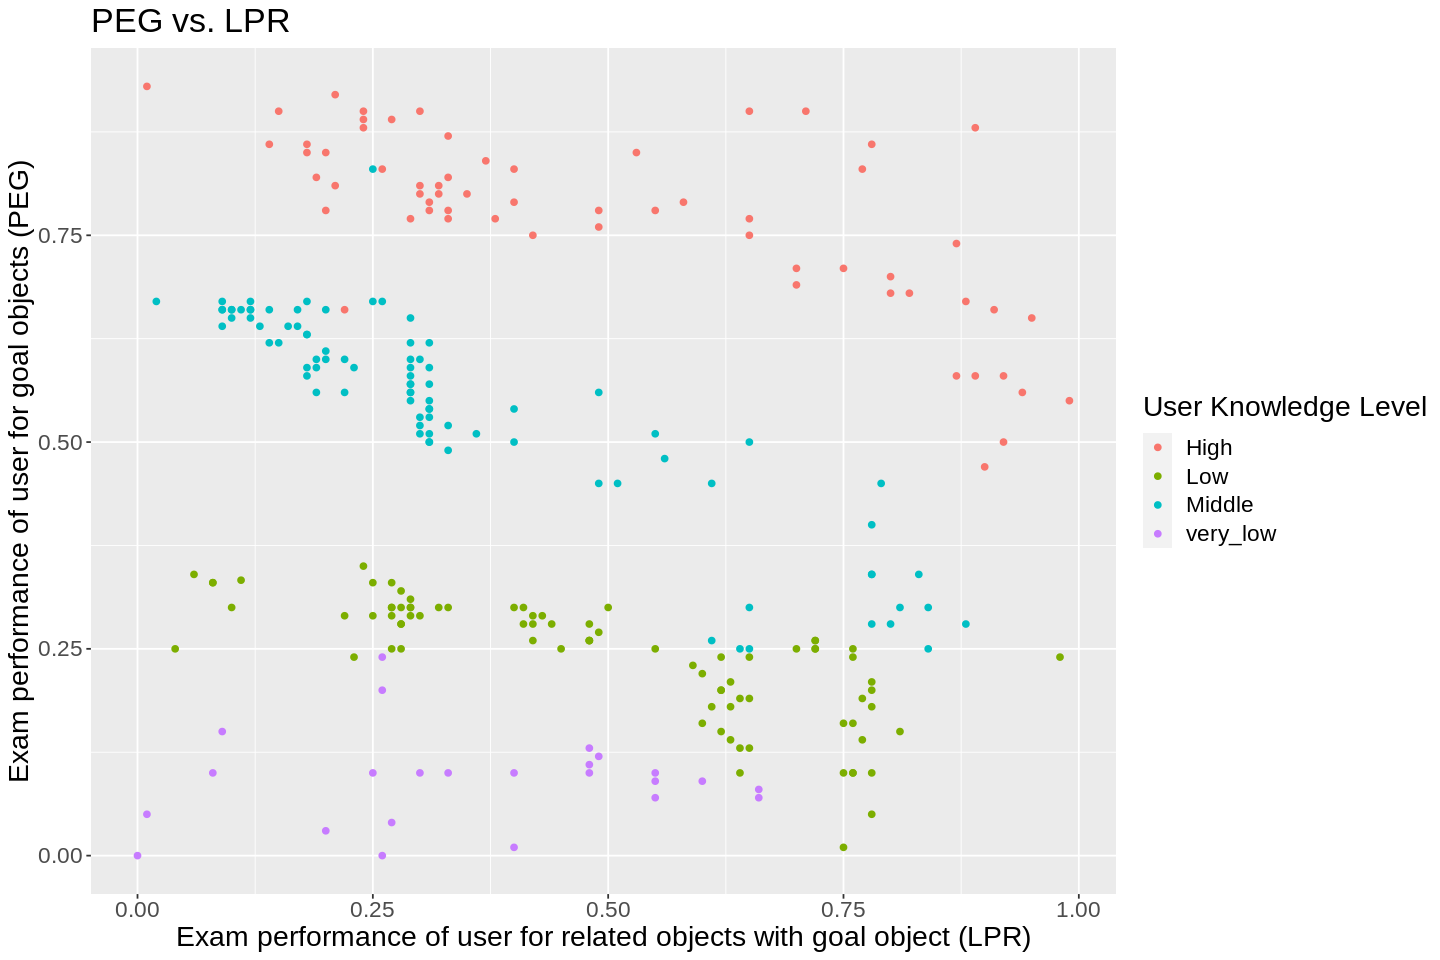

In [3]:
# visualizing training data
options(repr.plot.width = 12, repr.plot.height = 8) # for display
user_train_plot = user_train %>%
        ggplot(aes(x = LPR, y = PEG, colour = UNS)) +
        labs(x = "Exam performance of user for related objects with goal object (LPR)",y = "Exam performance of user for goal objects (PEG)", colour = 'User Knowledge Level') +
        ggtitle("PEG vs. LPR") +
        geom_point() +
        theme(text = element_text(size = 17))
user_train_plot

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.9495390,5,0.009979458,Preprocessor1_Model01
6,accuracy,multiclass,0.9533880,5,0.013367693,Preprocessor1_Model02
11,accuracy,multiclass,0.9258644,5,0.017041099,Preprocessor1_Model03
16,accuracy,multiclass,0.9064046,5,0.021225348,Preprocessor1_Model04
21,accuracy,multiclass,0.8675660,5,0.028808901,Preprocessor1_Model05
26,accuracy,multiclass,0.8480335,5,0.032004476,Preprocessor1_Model06
31,accuracy,multiclass,0.8478101,5,0.036490987,Preprocessor1_Model07
36,accuracy,multiclass,0.8478101,5,0.036490987,Preprocessor1_Model08
41,accuracy,multiclass,0.8325678,5,0.026597795,Preprocessor1_Model09


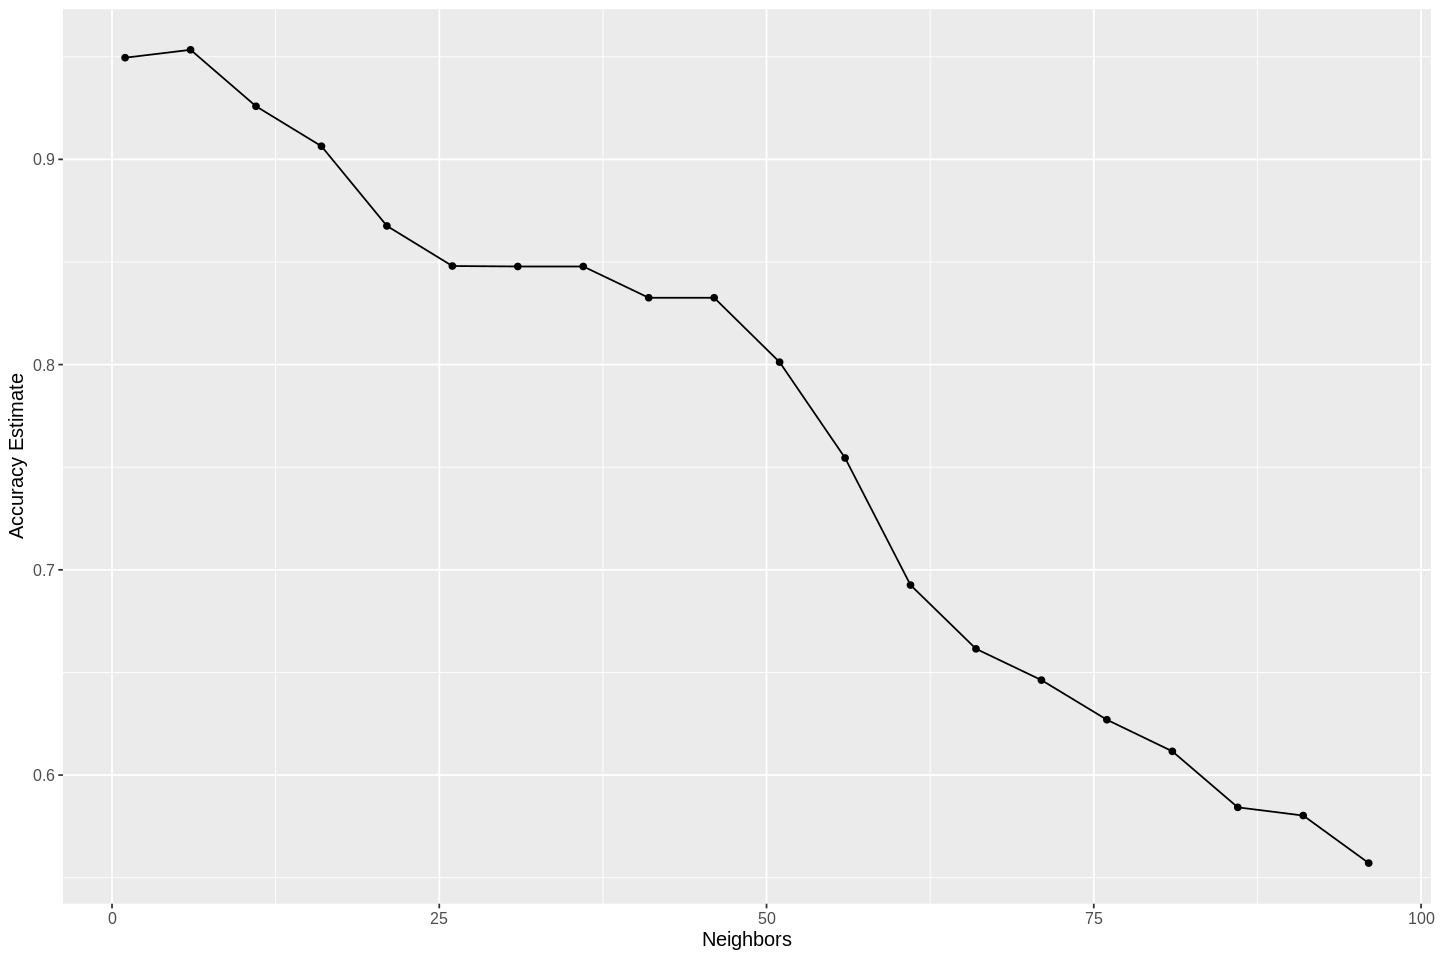

In [6]:
# prepare for data modelling
user_recipe <- recipe(UNS ~ LPR + PEG , data = user_train)
# create classifier and using cross-validation for parameter value selection (K)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")
# 5-fold cross-validation
user_vfold <- vfold_cv(user_train, v = 5, strata = "UNS")
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))
# train classifier with training data
user_results <- workflow() %>%
      add_recipe(user_recipe) %>%
      add_model(knn_spec) %>%
      tune_grid(user_vfold, grid = k_vals) %>%
      collect_metrics()
accuracies <- user_results %>%
      filter(.metric == "accuracy")
accuracies
# look for K with highest accuracy
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y= mean)) +
      geom_point() + 
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") + 
      theme(text = element_text(size = 12))
accuracy_vs_k

In [10]:
# from accuracy_vs_k above, we see 6 is the best value for K
# final model with best value K
final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) %>%
      set_engine("kknn") %>%
      set_mode("classification")

final_fit <- workflow() %>%
      add_recipe(user_recipe) %>%
      add_model(final_spec) %>%
      fit(data = user_train)

# predict labels for testing data
final_predictions <- predict(final_fit, user_test) %>%
      bind_cols(user_test)
final_predictions
# find statistics about our model quality
final_metrics <- final_predictions %>%
      metrics(truth = UNS, estimate = .pred_class)
final_metrics
# confusion matrix for classifier
final_conf_mat <- final_predictions %>%
      conf_mat(truth = UNS, estimate = .pred_class)
final_conf_mat

.pred_class,LPR,PEG,UNS
<fct>,<dbl>,<dbl>,<fct>
very_low,0.26,0.05,Very Low
Low,0.60,0.14,Low
High,0.60,0.85,High
High,0.67,0.85,High
High,0.30,0.90,High
Low,0.50,0.30,Low
Middle,0.50,0.50,Middle
Low,0.68,0.15,Low
High,0.77,0.80,High


ERROR: [1m[33mError[39m:[22m
[33m![39m In metric: `accuracy`
Problem while computing `.estimate = metric_fn(truth = UNS, estimate = .pred_class, na_rm = na_rm)`.
